## 1. Dependencias e Bibliotecas
Aqui importamos todas as bibliotecas e pacotes necessários para as etapas de processamento de dados, vetorização, treinamento e visualização.

In [32]:
import os
import logging
import zipfile
import requests
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Modelo Word2Vec
Definimos aqui a classe Word2VecModel, que encapsula a funcionalidade de download, carregamento e interação com o modelo Word2Vec. A classe permite recuperar vetores de palavras, encontrar palavras semelhantes e mostrar resultados com base no vocabulário fornecido.


In [33]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Word2VecModel:
    def __init__(self, vocab):
        self.vocab = vocab
        self.model = self._load_model()

    def _download_and_extract_model(self, url, extract_to='.'):
        local_zip_file = "w2v.vectors.zip"
        logging.info(f"Downloading the model from {url}...")
        response = requests.get(url)
        with open(local_zip_file, 'wb') as f:
            f.write(response.content)

        logging.info("Extracting the zip file...")
        with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        logging.info("Model downloaded and extracted successfully.")

    def _load_model(self):
        model_dir = os.path.join(os.getcwd(), 'models')
        model_file = os.path.join(model_dir, 'w2v.vectors.kv')
        if not os.path.exists(model_file):
            os.makedirs(model_dir, exist_ok=True)
            self._download_and_extract_model(
                'https://github.com/rdenadai/WordEmbeddingPortugues/releases/download/0.5/w2v.vectors.zip',
                extract_to=model_dir
            )
        logging.info("Loading the Word2Vec model...")
        model = KeyedVectors.load(model_file, mmap='r')
        logging.info("Model loaded successfully.")
        return model

    def get_vocab_size(self):
        return len(self.vocab)

    def most_similar(self, word, topn=3):
        return self.model.most_similar(word, topn=topn)

    def display_similar_words(self, words, topn=3):
        for word in words:
            print(f"\n{word}:")
            print("-" * 28)
            similar_words = self.most_similar(word, topn=topn)
            for similar_word, similarity in similar_words:
                print(f"{similar_word:<20} {similarity:.5f}")

    def get_vector(self, word):
        if word in self.model:
            return self.model[word]
        else:
            logging.warning(f"The word '{word}' is not in the vocabulary.")
            return None


### 2.1 Testes com o Modelo
Realizamos testes automáticos com a classe Word2VecModel para verificar se o tamanho do vocabulário, a busca de palavras semelhantes e a recuperação de vetores funcionam conforme o esperado.

In [34]:
def test_word2vec_model():
    vocab = [
        "preto", "branco", "pássaro", "lobo", "mulher", "sexo", "montanha",
        "oceano", "lua", "amor", "senhor", "médico", "doença", "febre", "dor"
    ]

    w2v_model = Word2VecModel(vocab)
    assert w2v_model.get_vocab_size() == len(vocab), "Vocabulary size mismatch"
    similar_words = w2v_model.most_similar("preto")
    assert len(similar_words) == 3, "Should return 3 similar words"
    vector = w2v_model.get_vector("preto")
    assert vector is not None, "Vector for 'preto' should not be None"
    assert isinstance(vector, np.ndarray), "Vector should be numpy.ndarray"
    print("Todos os testes passaram com sucesso!")

test_word2vec_model()

Todos os testes passaram com sucesso!


### 2.2 Exemplos de Uso
São desenvolvidos xemplos práticos do uso da classe Word2VecModel, como o de obter vetores de palavras e exibir palavras mais semelhantes dentro de um vocabulário específico.

In [35]:
vocab = [
    "preto", "branco", "pássaro", "lobo", "mulher", "montanha", "oceano", "amor", "médico"
]
w2v_model = Word2VecModel(vocab)


word = "preto"
vector = w2v_model.get_vector(word)
if vector is not None:
    print(f"\nVector for the word '{word}':")
    print(vector)


w2v_model.display_similar_words(["preto", "branco", "pássaro"])


Vector for the word 'preto':
[-0.18456692  0.45947403 -0.3821056  -0.02077596 -0.23175432  0.07987644
 -0.3943945   0.76432955  0.46100053 -0.42329612  0.10303371 -0.5554464
 -0.02964008  0.46156192 -0.33882576  0.5367816  -0.37528178  0.3743576
 -0.33563468  0.06717291 -0.3518185  -0.33390772  0.3943198  -0.11014716
  0.35076675  0.20479676 -0.21331453  0.5136635   0.04756886  0.01480213
 -0.18874457 -0.019419    0.02637832 -0.15573753 -0.46401948 -0.4600487
  0.45187503 -0.77291965  0.5112315  -0.40727443  0.36893058 -0.50125456
  0.29415026  0.27494213 -0.12086222 -0.5641251   0.22782342 -0.04439939
 -0.5548213  -0.12074754  0.4284054   0.20094873  0.28850272 -0.15562855
 -0.44299254  0.03049284 -0.2979641   0.11766719 -0.11960624 -0.01153767
  0.35770217 -0.2530105  -0.91969466 -0.48409802 -0.00895272  0.1177898
 -0.44785565 -0.57226074  0.4965827  -0.14205226  0.07649645  0.07154312
  0.08092815 -0.13254258  0.51889384  0.248033    0.19830738 -0.12169341
 -0.02046384 -0.0416936  

## 3. Carregamento e Processamento do dataset
Nesta parte, carregamos o dataset com dados aumentados e processados. Codificamos a coluna 'intention' com LabelEncoder, aplicamos as embeddings do Word2Vec nas perguntas processadas e preparamos os dados para o treinamento.

In [36]:
path_database = "data_augmented.xlsx"
df = pd.read_excel(path_database)

label_encoder = LabelEncoder()
df['intention_encoded'] = label_encoder.fit_transform(df['intention'])

df = df.drop(columns=['intention', 'question'])

vocab = df['processed_question'].str.split(',').explode().unique().tolist()
word2vec_model = Word2VecModel(vocab)

def get_word2vec_embeddings(text):
    embeddings = [word2vec_model.get_vector(word) for word in text.split(',') if word2vec_model.get_vector(word) is not None]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(word2vec_model.model.vector_size)

df['question_embeddings'] = df['processed_question'].apply(get_word2vec_embeddings)

## 4. Treinamento

### 4.1 Métodos auxiliares
O método abaixo é definido para a comparação dos resultados entre os modelos. Também, são definidos funções de testes para o Naive Bayes e SVM.

In [37]:
def calculate_scores_and_print_cm(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')

    print(f"Acurácia: {accuracy}\nPrecisão: {precision}\nRecall: {recall}\nF1 Score: {f1score}")
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
    plt.show()
    return accuracy, precision, recall, f1score

X_mock, y_mock = make_classification(n_samples=1000, n_features=10, n_informative=5, n_classes=3, n_clusters_per_class=1, random_state=42)
X_train_mock, X_test_mock, y_train_mock, y_test_mock = train_test_split(X_mock, y_mock, test_size=0.2, random_state=42)

def test_naive_bayes_model_mock():
    # Treinamento do modelo Naive Bayes com dados simulados
    nb_model = GaussianNB()
    nb_model.fit(X_train_mock, y_train_mock)
    y_pred_nb_mock = nb_model.predict(X_test_mock)

    # Avaliação do modelo
    accuracy_nb, precision_nb, recall_nb, f1score_nb = calculate_scores_and_print_cm(y_test_mock, y_pred_nb_mock)

    # Verificações para garantir que as métricas estão dentro dos limites esperados
    assert accuracy_nb > 0.5, "Acurácia do Naive Bayes com dados fictícios abaixo do esperado"
    assert precision_nb > 0.5, "Precisão do Naive Bayes com dados fictícios abaixo do esperado"
    assert recall_nb > 0.5, "Recall do Naive Bayes com dados fictícios abaixo do esperado"
    assert f1score_nb > 0.5, "F1-score do Naive Bayes com dados fictícios abaixo do esperado"

    print("Testes do modelo Naive Bayes com dados fictícios passaram com sucesso!")

def test_svm_model_mock():
    # Treinamento do modelo SVM com dados simulados
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_mock, y_train_mock)
    y_pred_svm_mock = svm_model.predict(X_test_mock)

    # Avaliação do modelo
    accuracy_svm, precision_svm, recall_svm, f1score_svm = calculate_scores_and_print_cm(y_test_mock, y_pred_svm_mock)

    # Verificações para garantir que as métricas estão dentro dos limites esperados
    assert accuracy_svm > 0.5, "Acurácia do SVM com dados fictícios abaixo do esperado"
    assert precision_svm > 0.5, "Precisão do SVM com dados fictícios abaixo do esperado"
    assert recall_svm > 0.5, "Recall do SVM com dados fictícios abaixo do esperado"
    assert f1score_svm > 0.5, "F1-score do SVM com dados fictícios abaixo do esperado"

    print("Testes do modelo SVM com dados fictícios passaram com sucesso!")

### 4.2 Testes para Naive Bayes e SVM

Acurácia: 0.885
Precisão: 0.8895876400173068
Recall: 0.885
F1 Score: 0.8857738345545291


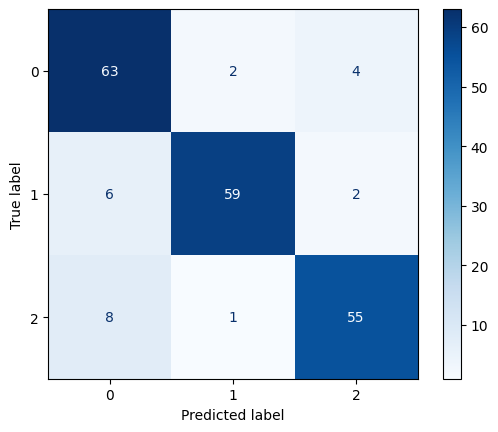

Testes do modelo Naive Bayes com dados fictícios passaram com sucesso!
Acurácia: 0.955
Precisão: 0.9567082494969819
Recall: 0.955
F1 Score: 0.9551274277914833


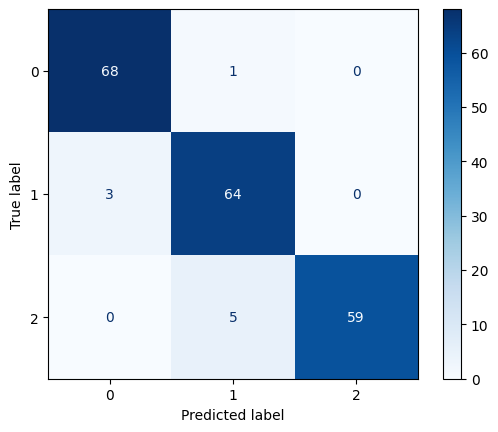

Testes do modelo SVM com dados fictícios passaram com sucesso!


In [38]:
test_naive_bayes_model_mock()
test_svm_model_mock()

### 4.3 Divisão entre conjuntos de teste e validação
É realizada a divisão dos dados em conjuntos de treinamento e teste, utilizando a função train_test_split para garantir que o modelo seja avaliado corretamente em dados não vistos anteriormente.

In [39]:
df = shuffle(df, random_state=42)
X = np.array(df['question_embeddings'].tolist())
y = to_categorical(df['intention_encoded'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.4 Naive Bayes
O modelo Naive Bayes é treinado com os dados de treinamento e seu desempenho é avaliado nos dados de teste. Calculamos a acurácia, precisão, recall e F1-score, além de exibir a matriz de confusão para uma visualização detalhada do desempenho.

Acurácia: 0.6029411764705882
Precisão: 0.6115287610856565
Recall: 0.6029411764705882
F1 Score: 0.5974641639590089


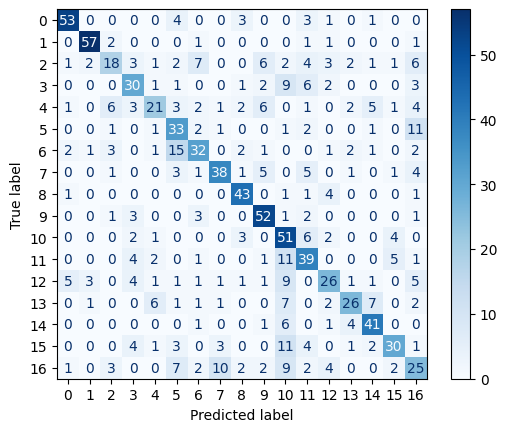

(0.6029411764705882,
 0.6115287610856565,
 0.6029411764705882,
 0.5974641639590089)

In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay

model = GaussianNB()
model.fit(X_train, np.argmax(y_train, axis=1))
y_pred = model.predict(X_test)

calculate_scores_and_print_cm(np.argmax(y_test, axis=1), y_pred)

### 4.5 Support-Vector-Machine (SVM) model
O modelo SVM (Support Vector Machine) também é utilizado, e comparamos seu desempenho com o modelo Naive Bayes. Para comparação, calculamos as métricas de desempenho e exibimos a matriz de confusão.

Acurácia: 0.8862745098039215
Precisão: 0.8884018531457476
Recall: 0.8862745098039215
F1 Score: 0.8859256388275111


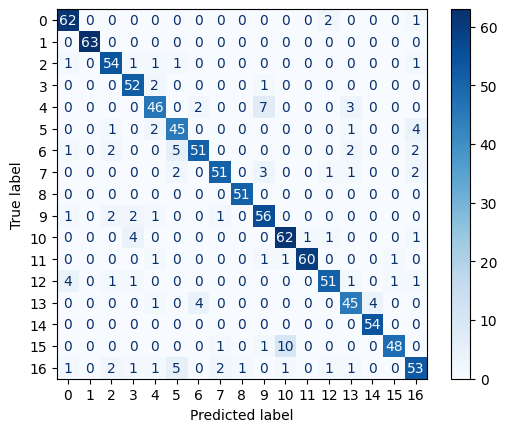

(0.8862745098039215,
 0.8884018531457476,
 0.8862745098039215,
 0.8859256388275111)

In [41]:
from sklearn.svm import SVC


svm_model = SVC(kernel='linear')
svm_model.fit(X_train, np.argmax(y_train, axis=1))
y_pred_svm = svm_model.predict(X_test)

calculate_scores_and_print_cm(np.argmax(y_test, axis=1), y_pred_svm)